# Training a Fully Connected Neural Network using Tensorflow

In [1]:
import os
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from cf_matrix import make_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.__version__

'2.6.0'

## Loading Training Data

Currently, the data we have is unbalanced and future updates should improve on this.

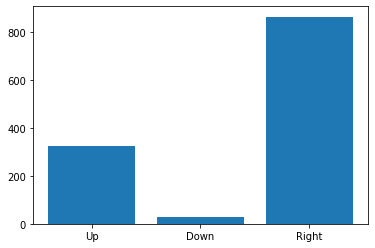

In [3]:
parent_dir = os.getcwd()
training_data_folder = os.path.join(parent_dir, "training_data_smaller")

up_folder = os.path.join(training_data_folder, "up")
down_folder = os.path.join(training_data_folder, "down")
right_folder = os.path.join(training_data_folder, "right")

up_images = os.listdir(up_folder)
down_images = os.listdir(down_folder)
right_images = os.listdir(right_folder)

up_count = len(up_images)
down_count = len(down_images)
right_count = len(right_images)

labels = ["Up","Down","Right"]
plt.bar(labels,[up_count, down_count, right_count])
plt.show()

## Preparing the Images for Training

The images are read using OpenCV, converted to grayscale, normalized to values between 0 and 1 and resized to a 40x40 image (scaled down by a factor of 10). They are then unrolled into a vector of 1600 pixels and added to the input feature array. Labels to the images are created based on the name of the image excluding their numbers, eg. up(0) -> up, and added to the known output array.

Input Array Shape: (1218, 1600)
Label Array Shape: (1218,)


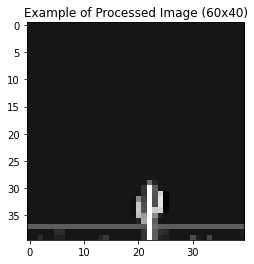

In [4]:
X = []
y = []

folder_list = [up_folder, down_folder, right_folder]

for curr_folder in folder_list:
    for image_name in os.listdir(curr_folder):
        label = image_name[:image_name.index("(")]

        image = cv.imread(os.path.join(curr_folder, image_name))
        grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        normalized = grayscale / 255
        # resized = cv.resize(normalized, (60, 40), interpolation=cv.INTER_AREA)
        resized = cv.resize(normalized, (40, 40), interpolation=cv.INTER_AREA)

        # Unrolling the matrices into vectors of 2400 pixels.
        X.append(np.ravel(resized))
        y.append(label)

X = np.array(X)
y = np.array(y)

# plt.imshow(np.reshape(X[0], (40,60)), cmap="gray")
plt.imshow(np.reshape(X[0], (40,40)), cmap="gray")
plt.title("Example of Processed Image (60x40)")

print("Input Array Shape:",X.shape)
print("Label Array Shape:",y.shape)

## Encoding the Categorical Labels (up, down and right) to One-Hot-Encoded

The original labels would be in the form of "up", "down", or "right". One hot encoding is used to represent these categorical data into binary features that can be used to train our network. The data is encoded as follows:

up - [1,0,0]

down - [0,1,0]

right - [0,0,1]

In [5]:
encoder = OneHotEncoder(categories=[["up", "down", "right"]])
y_encoded = np.array(encoder.fit_transform(y.reshape(-1,1)).toarray())

print(y_encoded[:5, :])
print(y_encoded.shape)


[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(1218, 3)


## Splitting the Dataset into Training and Test Data

The dataset is split into a 80/20 split where 80% of the data is used for the training set and 20% is used for the test set. Due to the nature of the arrangement of the data, the dataset is also shuffled.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=True)

## Configuring the Network

The model is a simple 3 layer densely connected neural network. The input layer has 1600 neurons corresponding to a 40x40 image, the hidden layer has 1000 neurons and the output layer has 3 units.

In [7]:
model = tf.keras.models.Sequential()

# Hidden Layer
# model.add(tf.keras.layers.Dense(units=100, input_shape=(2400,), activation="relu"))
model.add(tf.keras.layers.Dense(units=1000, input_shape=(1600,), activation="relu"))
# 3 output units, one for each of the possible keys to press.
model.add(tf.keras.layers.Dense(units=3, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              1601000   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3003      
Total params: 1,604,003
Trainable params: 1,604,003
Non-trainable params: 0
_________________________________________________________________


## Compile and Train

The current model is optimized using stochastic gradient descent (sgd) on categorical cross entropy. I also implemented an option to use early stopping while training to monitor and combat overfitting if necessary. To use this, pass ```early_stopping``` into a list of callbacks in ```model.fit()```, eg. ```model.fit(...callbacks=[early_stopping])```

In [8]:
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min")

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
31/31 [==============================] - 1s 15ms/step - loss: 0.7586 - accuracy: 0.6745 - val_loss: 0.6228 - val_accuracy: 0.7049
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.6082 - accuracy: 0.7300 - val_loss: 0.5587 - val_accuracy: 0.7213
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.5568 - accuracy: 0.7926 - val_loss: 0.5145 - val_accuracy: 0.7869
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.5233 - accuracy: 0.8337 - val_loss: 0.4776 - val_accuracy: 0.8607
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.4899 - accuracy: 0.8696 - val_loss: 0.4513 - val_accuracy: 0.8607
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 0.4602 - accuracy: 0.8840 - val_loss: 0.4204 - val_accuracy: 0.9057
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 0.4353 - accuracy: 0.8994 - val_loss: 0.4369 - val_accuracy: 0.9549
Epoch 8/1

## Plotting Learning Curves

Learning curves are plots that plot learning or improvement against time. When training, I also passed in the test set for validation that should theoretically give an idea how well the model is generalizing (I believe better practice would be to another separate cross validation dataset on bigger datasets). With the calculation of both the training loss and validation loss while training, the following cell then makes use of the training history and plots an optimization learning curve.

Ideally, in order to be a good fit, we we would want both the training and validation losses to decrease to a point of stability with a minimal gap between the losses. Training loss should also be lower than the validation loss.

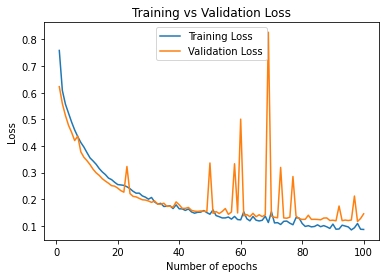

In [9]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epoch_axis = [i+1 for i in range(len(loss))]

plt.plot(epoch_axis, loss, label="Training Loss")
plt.plot(epoch_axis, val_loss, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Model Evaluation

In order to evaluate the model, the cell below creates a classification report to display metrics in terms of precision, recall and the f-score. A confusion matrix is then generated to view where the model made classification errors. Most commonly, as of now, the model slightly misclassifies running to the right as jumping or ducking.

              precision    recall  f1-score   support

          Up       1.00      0.90      0.95        68
        Down       1.00      0.75      0.86         4
       Right       0.96      1.00      0.98       172

    accuracy                           0.97       244
   macro avg       0.99      0.88      0.93       244
weighted avg       0.97      0.97      0.97       244



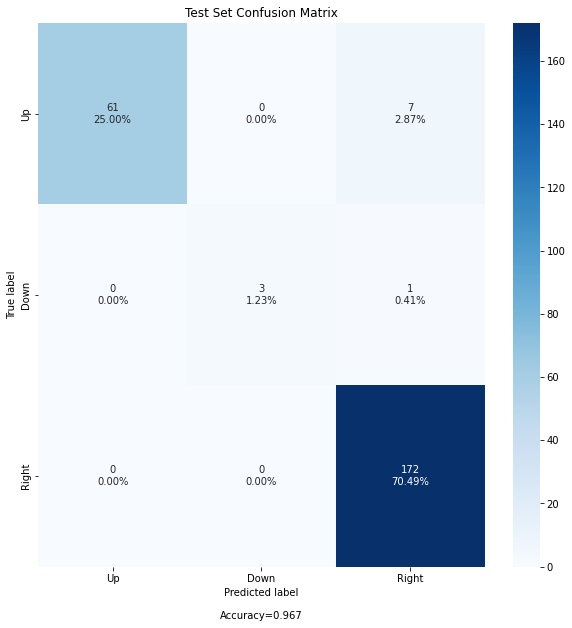

In [10]:
test_set_predictions = np.argmax(model.predict(X_test), axis=1)
original_test_output = np.argmax(y_test, axis=1)

test_report = classification_report(original_test_output, test_set_predictions, target_names=labels)
print(test_report)

matrix = confusion_matrix(original_test_output, test_set_predictions)
make_confusion_matrix(matrix, categories=labels, figsize=(10,10), title="Test Set Confusion Matrix")

## Exporting the Model

The main model which I find to be best performing is saved under "saved_model". Hence, at the current time, I don't want to overwrite this. Instead, the following cell will now prompt for a model name which will be saved under a folder called "test_models"

In [12]:
if "saved_model" not in os.listdir(parent_dir):
    os.mkdir(os.path.join(parent_dir, "saved_model"))
    model.save("saved_model")
    
else:
    if "test_models" not in os.listdir(parent_dir):
        os.mkdir(os.path.join(parent_dir, "test_models"))
        
    test_models_directory = os.path.join(parent_dir, "test_models")

    model_name = input("Enter the model name:")
    model.save(os.path.join(test_models_directory, model_name))

INFO:tensorflow:Assets written to: c:\Users\Naim\Desktop\Dev Work\MachineLearning\dinosaur-game-ai\test_models\smaller_more_data\assets
